<h1>On the Importance of Hyperparameter Selection when Choosing Control Variables with LASSO<h1>

In [37]:
import sys
import os

import numpy as np
import pandas as pd
import sklearn
import numpy.matlib

from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import norm # Needed for the calculation of penalties


# Check software versions
print('### Python version: ' + __import__('sys').version) # 3.8.5
print('### NumPy version: ' + np.__version__) # 1.19.2
print('### Scikit-learn version: ' + sklearn.__version__) # 0.23.2
print('------------')


### Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
### NumPy version: 1.19.2
### Scikit-learn version: 0.23.2
------------


<h2>Define Functions<h2>

<h5>The following functions are used to generate additional features/control variables for the regressions.<h5>

In [38]:
def genDifs(states, theData):
    # Data is assumed to be sorted
    stateChange = np.where(states[:-1] != states[1:])
    stateChange = np.append(stateChange,states.shape[0])
    
    theDif = np.diff(theData[0:stateChange[0]+1])
    for i in range(stateChange.shape[0]-1):
        theDif = np.append(theDif,np.diff(theData[stateChange[i]+1:stateChange[i+1]+1]))

    return theDif

def genLags(states,theData):
    # Data is assumed to be sorted
    # Will delete the last element of each state
    stateChange = np.where(states[:-1] != states[1:])
    stateChange = np.append(stateChange,states.shape[0])
    myStates = data[0:stateChange[0],0]
    for i in range(stateChange.shape[0]-1):
        myStates = np.append(myStates,data[stateChange[i]+1:stateChange[i+1],0])
    myStates = np.delete(myStates,600)
    
    differentstates = np.unique(myStates)
    theLag = np.zeros([myStates.shape[0],1])

    for i in differentstates:
        I1 = np.where(myStates == i)[0]
        I2 = np.where(states == i)[0]
        theLag[I1] = theData[I2[:-1]].reshape(I1.shape[0],1)

    return theLag

def genMeans(states,theData):
    # Data is assumed to be sorted
    # Will delete the last element of each state
    stateChange = np.where(states[:-1] != states[1:])
    stateChange = np.append(stateChange,states.shape[0])
    myStates = data[0:stateChange[0],0]
    for i in range(stateChange.shape[0]-1):
        myStates = np.append(myStates,data[stateChange[i]+1:stateChange[i+1],0])
    myStates = np.delete(myStates,600)
    
    differentstates = np.unique(myStates)
    theMeans = np.zeros([myStates.shape[0],1])

    for i in differentstates:
        I1 = np.where(myStates == i)[0]
        I2 = np.where(states == i)[0]
        theMeans[I1] = np.matlib.repmat(np.mean(theData[I2]),I1.shape[0],1)

    return theMeans

def genInitialLevels(states,theData):
    # Data is assumed to be sorted
    # Will delete the last element of each state
    stateChange = np.where(states[:-1] != states[1:])
    stateChange = np.append(stateChange,states.shape[0])
    myStates = data[0:stateChange[0],0]
    for i in range(stateChange.shape[0]-1):
        myStates = np.append(myStates,data[stateChange[i]+1:stateChange[i+1],0])
    myStates = np.delete(myStates,600)
    
    differentstates = np.unique(myStates)
    theLevels = np.zeros([myStates.shape[0],1])

    for i in differentstates:
        I1 = np.where(myStates == i)[0]
        I2 = np.where(states == i)[0]
        theLevels[I1] = np.matlib.repmat(theData[I2][0],I1.shape[0],1)

    return theLevels

def genInitialDif(states,theData):
    # Data is assumed to be sorted
    # Will delete the last element of each state
    stateChange = np.where(states[:-1] != states[1:])
    stateChange = np.append(stateChange,states.shape[0])
    myStates = data[0:stateChange[0],0]
    for i in range(stateChange.shape[0]-1):
        myStates = np.append(myStates,data[stateChange[i]+1:stateChange[i+1],0])
    myStates = np.delete(myStates,600)
    
    differentstates = np.unique(myStates)
    theDifs = np.zeros([myStates.shape[0],1])

    for i in differentstates:
        I1 = np.where(myStates == i)[0]
        theDifs[I1] = np.matlib.repmat(theData[I1][0],I1.shape[0],1)

    return theDifs

The following function is used to generate clustered errors

In [39]:


def clusteredErrors(controls, dependent, coef, states):

    DXMX = controls[:,1:] @ np.linalg.inv(np.transpose(controls[:,1:])@controls[:,1:])
    xx = controls[:,0].reshape((controls[:,0].shape[0],1))
    x = controls[:,0].reshape((controls[:,0].shape[0],1))-DXMX@(np.transpose(controls[:,1:])@xx)
    DyV = dependent - DXMX@(np.transpose(controls[:,1:])@dependent)
    error = np.diag(DyV - coef*(x)).reshape((600,1))
    XTXinv = np.linalg.inv(np.transpose(x)@x)
    n = error.shape[0]
    dim = controls.shape[1]
    differentstates = np.unique(states)
    V = 0
    for i in differentstates:
        I = np.where(states == i)[0]
        temp = np.transpose(x[I,:])@error[I,:]
        V = V + temp @ np.transpose(temp)
    vcluster = ((n-1)/(n-dim))*(states.shape[0]/(states.shape[0]-1))*(XTXinv@V@np.transpose(XTXinv))

    se = np.sqrt(np.diag(vcluster))
    return se


After the generation of control variables, we may have colinearity. The following function aims to find the subset of features/control variables that do not have colinearity.

In [40]:
def findNonCollinear(controls, tol = 1e-16):
    
    if tol < 1e-16:
        print('TOLERANCE MIGHT BE TOO SMALL. 1e-16 or higher is suggested.')
    
    print('')
    print('Finding non-colinear variables')
    p = controls.shape[1]
    keep = numpy.arange(0,p)
    
    for i in range(1, p+1):
        sys.stdout.write('.')
        sys.stdout.flush()
        use = (keep != p-i)
        if use.shape[0]< p:
            newTemp = np.matlib.repmat(False, p-use.shape[0],1).reshape(p-use.shape[0],)
            use = np.concatenate((use, newTemp),0)
        e = controls[:,p-i]
        e = e - controls[:,use]@np.linalg.pinv(controls[:,use].T @controls[:,use]) \
            @ np.transpose(controls[:,use])@e

        temp = np.sum(np.square(e))
        tempDen = np.sum(np.square(controls[:,p-i]))
        if tempDen != 0:
            temp = temp/tempDen
        else:
            #print(p-i)
            keep = np.setdiff1d(keep, p-i)
            
        if np.isnan(temp):
            print(p-i)
            keep = np.setdiff1d(keep, p-i)
        elif temp<tol:
            keep = np.setdiff1d(keep, p-i)
    print('')
    return keep

<h3>The following two functions are the main functions for Lasso. I could not use existing packages, because of the way the weight matrix is calculated. Therefore, I needed to create my own Lasso Shooting function. I took advantage of the replication files of 'Belloni, Cherhoznukov, and Hansen 2014'. Their files were in Matlab. I implemented their codes using Python. <h3>

In [41]:
def LassoShooting(X, y, myLam, loadings, myModel, maxiter = 10000, optTol = 1e-5):
    # This function is derived from the replication files of Belloni, Cherhoznukov,
    # and Hansen 2014 "Inference on Treatment Effects after Selection among High-Dimensional Controls"
    # The replication files included Matlab codes.
    
    p = X.shape[1]
    
    XX = np.transpose(X)@X
    Xy = np.transpose(X)@y
    
    
    #myBeta = myModel.fit(X, y).coef_
    myBeta = np.linalg.inv(XX + myLam*np.diag(np.ones(p)))@Xy
    m = 0
    
    XX2 = XX*2
    Xy2 = Xy*2
    
    while m < maxiter:
        beta_old = myBeta.copy()
        
        for j in range(p):
            S0 = np.sum(XX2[j,:]@myBeta) - XX2[j,j]*myBeta[j] - Xy2[j]
            thresh = myLam*loadings[j]
            if S0 > thresh:
                #print('Previous beta is {: .5f}'.format(myBeta[j,]))
                myBeta[j] = (thresh - S0)/XX2[j,j]
                #print('New beta is {: .5f}'.format(myBeta[j,]))
            elif S0 < -thresh:
                #print('Previous beta is {: .5f}'.format(myBeta[j,]))
                myBeta[j] = (-thresh - S0)/XX2[j,j]
                #print('New beta is {: .5f}'.format(myBeta[j,]))
            elif np.abs(S0)<=thresh:
                myBeta[j] = 0

                
        m = m + 1 
        #print('Iteration in Lasso Shooting {}'.format(m))
        
        if np.sum(np.abs(myBeta-beta_old))<optTol:
            break
    if m >= maxiter:
        print('No convergence in coefficient calculation')
        
    return myBeta

def chooseVariables(X,y, myLam, verbose = 0, maxIter = 100, useSeed = True):
    reg_temp = LinearRegression().fit(X, y)

    errors = y-reg_temp.predict(X)
    loading0 = X*np.repeat(errors.reshape((-1,1)),X.shape[1],1)
    loading0 = np.sqrt(np.sum(np.square(loading0),axis=0))/np.sqrt(X.shape[0])
    
    if useSeed:
        myModel = linear_model.Ridge(alpha=myLam, random_state = 42) 
        # Initial beta will be calculated through Ridge regression.
    else:
        myModel = linear_model.Ridge(alpha=myLam)
        
    initialBeta = LassoShooting(X, y, myLam, loading0, myModel)
    
   
    theResiduals = y - X@initialBeta
    
    kk = 1
    
    loading1 = X*np.repeat(theResiduals.reshape((-1,1)), X.shape[1],1)
    loading1 = np.sqrt(np.sum(np.square(loading1),axis=0))/np.sqrt(X.shape[0])
    
    while np.linalg.norm(loading1-loading0) > 1e-4 and kk < maxIter:
        
        myBeta = LassoShooting(X, y, myLam, loading1, myModel)
    
        Indbeta = np.where(myBeta != 0)[0]

        loading0 = loading1
        loading1 = X*np.repeat((y-X@myBeta).reshape((-1,1)) ,X.shape[1],1)
        loading1 = np.sqrt(np.sum(np.square(loading1),axis=0))/np.sqrt(X.shape[0])
        if verbose == 1:
            print('Iteration {: }, shape of beta is {: }'.format(kk, Indbeta.shape[0]))
        kk = kk + 1
    if kk >= maxIter:
        print('No convergence in Loadings')
    if verbose == 1:
        print('')
    myBeta = myBeta.reshape(-1,1)
    loading1 = loading1.reshape(-1,1)
    loss = np.sum(np.square(y-X@myBeta)) \
        + myLam*np.sum(np.abs(myBeta).T @ loading1)
    #loss = r2_score(y, X@myBeta, multioutput='variance_weighted')

    return Indbeta, loss

<h3>Run Initial Regressions to see if we Correclty Read the Data<h3>

In [42]:
# Read data
theData = pd.read_table('levitt_ex.dat', header=0, na_values='?')

# Summarize some information
theData.info()

# Use Python regression package to obtain clustered standard errors
# and check if the results are consistent. Panda package is used for this
# exercise.
# Keep only years 85 to 97 (as the original papers)
myData = theData[theData['year']>84]
myData = myData[myData['year']<98]
# Drop DC 
myData = myData[myData['statenum']!=9]

# Show how the data looks like
myData.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   statenum  1734 non-null   int64  
 1   year      1734 non-null   int64  
 2   popul     1530 non-null   float64
 3   lpc_viol  1320 non-null   float64
 4   lpc_prop  1320 non-null   float64
 5   lpc_murd  1320 non-null   float64
 6   efamurd   663 non-null    float64
 7   efaviol   663 non-null    float64
 8   efaprop   663 non-null    float64
 9   xxprison  1275 non-null   float64
 10  xxpolice  1275 non-null   float64
 11  xxunemp   1326 non-null   float64
 12  xxincome  1326 non-null   float64
 13  xxpover   918 non-null    float64
 14  xxafdc15  714 non-null    float64
 15  xxgunlaw  1683 non-null   float64
 16  xxbeer    714 non-null    float64
dtypes: float64(15), int64(2)
memory usage: 230.4 KB


,statenum,year,popul,lpc_viol,lpc_prop,lpc_murd,efamurd,efaviol,efaprop,xxprison,xxpolice,xxunemp,xxincome,xxpover,xxafdc15,xxgunlaw,xxbeer
19,1,85,3973.0,1.532720,3.562942,-2.305862,0.000860,0.009147,0.036163,0.952666,0.762663,0.08908,9.703193,20.6,3077.629,1.0,18.7
20,1,86,3992.0,1.734365,3.634252,-2.278332,0.001346,0.014100,0.055097,0.995291,0.790903,0.09833,9.745950,23.8,2805.778,1.0,19.3
21,1,87,4015.0,1.738170,3.678351,-2.357621,0.005252,0.031547,0.104993,1.058402,0.818914,0.07775,9.762092,21.3,3455.742,1.0,19.4
22,1,88,4024.0,1.745476,3.714935,-2.288764,0.009683,0.051825,0.163302,1.143818,0.880334,0.07208,9.781770,19.3,3210.000,1.0,19.4
23,1,89,4030.0,1.797903,3.719690,-2.258889,0.022214,0.088065,0.250177,1.121946,0.941032,0.07025,9.802527,18.9,3789.493,1.0,19.4


In [43]:
from linearmodels.panel import FirstDifferenceOLS

# Generate year dummies
dummy2 = pd.get_dummies(myData['year'], prefix='y')
# Append year dummies to original data
allData = pd.concat([myData, dummy2], axis = 1)
# MultiIndex, entity - time. This is needed to run FirstDifferenceOLS and get
# clustered standard errors.
allData = allData.set_index(['statenum','year'])
# All exogenous variables with year dummies
exog_vars = ['efaviol','xxprison', 'xxpolice', 'xxunemp', 'xxincome', 'xxpover','xxafdc15', 'xxgunlaw','xxbeer','y_86','y_87','y_88','y_89','y_90','y_91','y_92','y_93','y_94','y_95','y_96','y_97']
exog = allData[exog_vars]
indep = allData['lpc_viol'] # Independent variable

# Run regression for Viol
mod = FirstDifferenceOLS(indep, exog) 
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:               lpc_viol   R-squared:                        0.2797
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.2386
No. Observations:                 600   R-squared (Within):               0.4848
Date:                Mon, Apr 05 2021   R-squared (Overall):              0.2404
Time:                        10:54:07   Log-likelihood                    741.96
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.708
Entities:                          50   P-value                           0.0000
Avg Obs:                       13.000   Distribution:                  F(21,579)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             28.382
                            

In [44]:
# Do same steps for prop
exog_vars = ['efaprop','xxprison', 'xxpolice', 'xxunemp', 'xxincome', 'xxpover','xxafdc15', 'xxgunlaw','xxbeer','y_86','y_87','y_88','y_89','y_90','y_91','y_92','y_93','y_94','y_95','y_96','y_97']
exog = allData[exog_vars]
indep = allData['lpc_prop']


mod = FirstDifferenceOLS(indep, exog)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:               lpc_prop   R-squared:                        0.2281
Estimator:         FirstDifferenceOLS   R-squared (Between):             -0.1329
No. Observations:                 600   R-squared (Within):               0.3641
Date:                Mon, Apr 05 2021   R-squared (Overall):             -0.1326
Time:                        10:54:09   Log-likelihood                    990.99
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.1471
Entities:                          50   P-value                           0.0000
Avg Obs:                       13.000   Distribution:                  F(21,579)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             40.238
                            

In [45]:
# Do same steps for murd

exog_vars = ['efamurd','xxprison', 'xxpolice', 'xxunemp', 'xxincome', 'xxpover','xxafdc15', 'xxgunlaw','xxbeer','y_86','y_87','y_88','y_89','y_90','y_91','y_92','y_93','y_94','y_95','y_96','y_97']
exog = allData[exog_vars]
indep = allData['lpc_murd']


mod = FirstDifferenceOLS(indep, exog)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:               lpc_murd   R-squared:                        0.0741
Estimator:         FirstDifferenceOLS   R-squared (Between):             -29.425
No. Observations:                 600   R-squared (Within):               0.0909
Date:                Mon, Apr 05 2021   R-squared (Overall):             -29.285
Time:                        10:54:12   Log-likelihood                   -26.085
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.2076
Entities:                          50   P-value                           0.0016
Avg Obs:                       13.000   Distribution:                  F(21,579)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):             13.818
                            

<h3>Switch to numpy dataset to be able to use sklearn packages<h3>

In [46]:
# In order to use sklearn, we need to switch to numpy dataset
# Save data as numpy
allData = theData.to_numpy()

# Get names of control and dependent variables
col_names = [c for c in theData.columns]
features = np.delete(col_names,np.s_[3:6],0) # Except time dummies and efa...
target = col_names[3:6] # The first one is viol, the second prop and third murd

#print('features: {} --- target: {}'.format(features, target))

# Delete Alaska, DC and Hawaii as in Belloni et. al, 2014 (Alaska and Hawaii
# are kept in Stata version, hence I only drop DC.)
DC = np.where(allData[:,0] != 9)[0]
data = allData[DC,:]
#alaska = np.where(data[:,0] != 2)[0]
#data = data[alaska,:]
#Hawaii = np.where(data[:,0] != 12)[0]
#data = data[Hawaii,:]

# Keep same years as in Belloni et. al, 2014
dropYear = np.where(97>=data[:,1])[0]
data = data[dropYear,:]
dropYear = np.where(85<=data[:,1])[0]
data = data[dropYear,:]

theTrend = (data[:,1].reshape(-1,1)-85)/12 # Normalized trend

# Data is already sorted, therefore the next lines are left as comments. But
# it is important to have sorted data as we calculate differences.
# ind = np.lexsort((data[:,1], data[:,0]))
# data = data[ind]

dependents = data[:,3:6] # dependent variables
xxControl = data[:,9:17] # Initial controls

<h3>Create control variables for numpy data<h3>

In [47]:
# Use genDifs function (defined above) to calculate differences. The first entry
# is state information and the second entry is the variables that we will take
# differences. The resulting data will have less observations because we take
# differences. In oder words, all the first years for each state will disappear.
difDependents = np.zeros([dependents.shape[0]-np.unique(data[:,0]).shape[0], dependents.shape[1]])
for i in range(dependents.shape[1]):
    difDependents[:,i] = genDifs(data[:,0],dependents[:,i])

difControls = np.zeros([xxControl.shape[0]-np.unique(data[:,0]).shape[0], xxControl.shape[1]])
for i in range(xxControl.shape[1]):
    difControls[:,i] = genDifs(data[:,0],xxControl[:,i])
       
# Use sklear package to create time dummies
enc = preprocessing.OneHotEncoder(sparse = False) # Sparse is false to keep the original structure

timeDummies = data[:,1].reshape(-1,1)

timeDummies = enc.fit_transform(timeDummies) #one hot encode categorical structures

# We need to drop first years as they disappear in differences
timeDummies = np.delete(timeDummies, np.where(timeDummies[:,0]==1), axis=0)
timeDummies = timeDummies[:,1:timeDummies.shape[1]]

# Unify time dummies with control variables.
dxxControls = np.concatenate((difControls, timeDummies),axis=1)

# Each regression needs to include efa... in addition to dxxControls. Next lines
# does it and appends it to dxxControls.
violControls = np.zeros([xxControl.shape[0]-np.unique(data[:,0]).shape[0], xxControl.shape[1]])
violControls = genDifs(data[:,0],data[:,7])
violControls = np.append(violControls[:,None], dxxControls,axis=1)
yViol = difDependents[:,0]

propControls = np.zeros([xxControl.shape[0]-np.unique(data[:,0]).shape[0], xxControl.shape[1]])
propControls = genDifs(data[:,0],data[:,8])
propControls = np.append(propControls[:,None], dxxControls,axis=1)
yProp = difDependents[:,1]

murdControls = np.zeros([xxControl.shape[0]-np.unique(data[:,0]).shape[0], xxControl.shape[1]])
murdControls = genDifs(data[:,0],data[:,6])
murdControls = np.append(murdControls[:,None], dxxControls,axis=1)
yMurd = difDependents[:,2]

# Get state indices by erasing the first entries, to make the length of data
# consistent.
states = data[:,0]
stateChange = np.where(states[:-1] != states[1:])
stateChange = np.append(stateChange,states.shape[0])
myStates = data[0:stateChange[0],0]
trend = theTrend[0:stateChange[0],0] # Normalized trend
trend = trend.reshape(-1,1)
for i in range(stateChange.shape[0]-1):
    myStates = np.append(myStates,data[stateChange[i]+1:stateChange[i+1],0])
    trend = np.append(trend,theTrend[stateChange[i]+1:stateChange[i+1],0])
myStates = np.delete(myStates,600)
trend = np.delete(trend,0)

<h3>Check if we get the same coefficients with sklearn<h3>

In [48]:
# Use sklearn package to run linear regressions. Error terms are manually 
# clustered. We want to see if the transition from pandas to numpy was done right.
# The first regression coefficients are the coefficients of interest.
reg_viol = LinearRegression().fit(violControls, yViol)
print('---------------------------------------------------------------------')
print('')
print('Coefficient of efaviol is: {: .3f}'.format(reg_viol.coef_[0]))
se_viol = clusteredErrors(violControls, yViol,reg_viol.coef_[0], myStates)
print('(Clustered) Standard error of efaviol is: {: .3f}'.format(se_viol[0]))
print('')

reg_prop = LinearRegression().fit(propControls, yProp)
print('Coefficient of efaprop is: {: .3f}'.format(reg_prop.coef_[0]))
se_prop = clusteredErrors(propControls, yProp,reg_prop.coef_[0], myStates)
print('(Clustered) Standard error of efaprop is: {: .3f}'.format(se_prop[0]))
print('')

reg_murd = LinearRegression().fit(murdControls, yMurd)
print('Coefficient of efamurd is: {: .3f}'.format(reg_murd.coef_[0]))
se_murd = clusteredErrors(murdControls, yMurd,reg_murd.coef_[0], myStates)
print('(Clustered) Standard error of efaviol is: {: .3f}'.format(se_murd[0]))
print('')
print('---------------------------------------------------------------------')

---------------------------------------------------------------------

Coefficient of efaviol is: -0.157
(Clustered) Standard error of efaviol is:  0.034

Coefficient of efaprop is: -0.106
(Clustered) Standard error of efaprop is:  0.021

Coefficient of efamurd is: -0.218
(Clustered) Standard error of efaviol is:  0.067

---------------------------------------------------------------------


<h4>Now that we have seen our data was correcctly specified, now I will create potential control variables using sklear package. Potential control variables include the following
    <br>
    1. Differences (dxxControls), already created.
    <br>
    2. Squared differences 3. Difference interactions 
    <br>
    4. Lags 
    <br>
    5. Squared Lags 
    <br>
    6. Means of xxControls 
    <br>
    7. Squares of the means of xxControls 
    <br>
    8. Initial levels 
    <br>
    9. Squared if initial levels 
    <br>
    10. Initial differences 
    <br>
    11. Squares of initial differences 
    <br>
    12. Interactions of the variables calculated in 1-11 with trends and square of trends 
    <br>
    There will also be calculations for efa..., but that is done later as it is specific to each regression. 
    <br>
    NOTE: The above is Stata version control variables, it creates 300 variables
<h4>

In [49]:
# The following normalizations are done in the Stata code provided by the paper

difControls[:,3] = difControls[:,3] /100
difControls[:,4] = difControls[:,4] /100
difControls[:,5] = difControls[:,5] /10000
difControls[:,7] = difControls[:,7] /100

allControls = difControls.copy()

allControls_all = xxControl.copy()
allControls_all[:,3] = allControls_all[:,3] /100
allControls_all[:,4] = allControls_all[:,4] /100
allControls_all[:,5] = allControls_all[:,5] /10000
allControls_all[:,7] = allControls_all[:,7] /100

controlNames = features[6:14]
controlNames = ["D" + names for names in controlNames ]
controlNames = np.asarray(controlNames)

In [50]:
# 1,2 and 3

polyf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interacts = polyf.fit_transform(allControls.copy())
interacts = interacts[:,8:]
theNames = polyf.get_feature_names(controlNames)
theNames = np.asarray(theNames)
theNames = theNames.reshape(-1,1)
theNames = theNames[8:]


# Generate only squares
for i in range(difControls.shape[1]):
    temp = np.square(allControls[:,i]).reshape(-1,1)
    allControls = np.concatenate((allControls,temp),1)

squareNames = [names + "2"  for names in controlNames]
squareNames = np.asarray(squareNames)
controlNames = controlNames.reshape(-1,1)
squareNames = squareNames.reshape(-1,1)
controlNames = np.concatenate((controlNames, squareNames),0)

allControls = np.concatenate((allControls, interacts),1)
controlNames = np.concatenate((controlNames,theNames),0)

In [51]:
# 4. & 5. Create lags and its squares

for i in range(allControls_all.shape[1]):
    temp = genLags(data[:,0],allControls_all[:,i])
    allControls = np.concatenate((allControls,temp),1)

for i in range(allControls_all.shape[1]):
    temp = genLags(data[:,0],allControls_all[:,i])
    allControls = np.concatenate((allControls,temp**2),1)

lagNames = ["Lxxprison", "Lxxpolice",  "Lxxunemp", "Lxxincome", "Lxxpover", 
            "Lxxafdc15","Lxxgunlaw", "Lxxbeer", "Lxxprison2", "Lxxpolice2",  
            "Lxxunemp2", "Lxxincome2", "Lxxpover2", "Lxxafdc152", 
            "Lxxgunlaw2", "Lxxbeer2" ]
lagNames = np.asarray(lagNames)
lagNames = lagNames.reshape(-1,1)

controlNames = np.concatenate((controlNames,lagNames),0)

In [52]:
# 6. & 7. Create means and its squares

for i in range(allControls_all.shape[1]):
    temp = genMeans(data[:,0],allControls_all[:,i])
    allControls = np.concatenate((allControls,temp),1)

for i in range(allControls_all.shape[1]):
    temp = genMeans(data[:,0],allControls_all[:,i])
    allControls = np.concatenate((allControls,temp**2),1)

meanNames = ["Mxxprison", 'Mxxpolice', 'Mxxunemp','Mxxincome', 'Mxxpover', 
             'Mxxafdc15', 'Mxxgunlaw','Mxxbeer', "Mxxprison2", 'Mxxpolice2', 
             'Mxxunemp2','Mxxincome2', 'Mxxpover2', 'Mxxafdc152', 'Mxxgunlaw2',
             'Mxxbeer2']
meanNames = np.asarray(meanNames)

meanNames = meanNames.reshape(-1,1)
controlNames = np.concatenate((controlNames,meanNames),0)

In [53]:
# 8. & 9. Get initial levels  and its squares
# These values are not calculated in Matlab version

for i in range(allControls_all.shape[1]):
    temp = genInitialLevels(data[:,0],allControls_all[:,i])
    allControls = np.concatenate((allControls,temp),1)
    
for i in range(allControls_all.shape[1]):
    temp = genInitialLevels(data[:,0],allControls_all[:,i])
    allControls = np.concatenate((allControls,temp**2),1)

ILevelNames = ['xxprison0', 'xxpolice0', 'xxunemp0', 'xxincome0', 'xxpover0',
                'xxafdc150','xxgunlaw0', 'xxbeer0', 'xxprison02', 'xxpolice02', 
                'xxunemp02', 'xxincome02', 'xxpover02','xxafdc1502',
                'xxgunlaw02', 'xxbeer02']

ILevelNames = np.asarray(ILevelNames)

ILevelNames = ILevelNames.reshape(-1,1)
controlNames = np.concatenate((controlNames,ILevelNames),0)

In [54]:
# 9. & 10. Get initial differences and its squares

for i in range(allControls_all.shape[1]):
    temp = genInitialDif(data[:,0],difControls[:,i])
    allControls = np.concatenate((allControls,temp),1)
    
for i in range(allControls_all.shape[1]):
    temp = genInitialDif(data[:,0],difControls[:,i])
    allControls = np.concatenate((allControls,temp**2),1)

DLevelNames = ['Dxxprison0', 'Dxxpolice0', 'Dxxunemp0', 'Dxxincome0', 'Dxxpover0',
               'Dxxafdc150','Dxxgunlaw0', 'Dxxbeer0', 'Dxxprison02', 'Dxxpolice02', 
               'Dxxunemp02', 'Dxxincome02', 'Dxxpover02','Dxxafdc1502',
               'Dxxgunlaw02', 'Dxxbeer02']

DLevelNames = np.asarray(DLevelNames)

DLevelNames = DLevelNames.reshape(-1,1)
controlNames = np.concatenate((controlNames,DLevelNames),0)

In [55]:
#12
trends = np.zeros((trend.shape[0],2))
trends[:,0] = trend
trends[:,1] = trend**2

trendNames = ['Xt', 'Xt2']
trendNames = np.asarray(trendNames)

interacNames = np.asarray(["                                                " \
                           for x in range(controlNames.shape[0]*2)])
interacNames = interacNames.reshape(-1,1)
shared = np.empty([allControls.shape[0], allControls.shape[1]*3])
shared[:,0:allControls.shape[1]] = allControls
j = 0
for i in range(allControls.shape[1]):
    temp = allControls[:,i]*trends[:,0]
    temp2 = allControls[:,i]*trends[:,1]
    shared[:,allControls.shape[1]+j] = temp
    shared[:,allControls.shape[1]+j+1] = temp2
    interacNames[j,0] = controlNames[i,0] + trendNames[0]
    interacNames[j+1,0] = controlNames[i,0] + trendNames[1]
    j = j +2

controlNames = np.concatenate((controlNames,interacNames),0)

<h5>Some feature have all values equal to 0. The next line drops those features.<h5>

In [56]:
idx = np.argwhere(np.all(shared[..., :] == 0, axis=0))
shared = np.delete(shared, idx, axis=1)
print('{} all zero features dropped'.format(idx.shape[0]))
print('Dropped features are {}:'.format(controlNames[idx]))
print('{} number of potential controls remaining in shared'.format(shared.shape[1]))
controlNames = np.delete(controlNames, idx).reshape(-1,1)

6 all zero features dropped
Dropped features are [[['Dxxgunlaw0']]

 [['Dxxgunlaw02']]

 [['Dxxgunlaw0Xt']]

 [['Dxxgunlaw0Xt2']]

 [['Dxxgunlaw02Xt']]

 [['Dxxgunlaw02Xt2']]]:
318 number of potential controls remaining in shared


<h5>Get violence specific controls:<h5>

In [69]:
# Violence specific controls

allViolControl = genDifs(data[:,0],data[:,7]).reshape(-1,1)


tempViol1 = genInitialLevels(data[:,0],data[:,7])
tempViol2 = genInitialDif(data[:,0],allViolControl)
tempViol3 = tempViol1**2
tempViol4 = tempViol2**2

allViolControl = np.concatenate((allViolControl, tempViol1),1)
allViolControl = np.concatenate((allViolControl, tempViol2),1)
allViolControl = np.concatenate((allViolControl, tempViol3),1)
allViolControl = np.concatenate((allViolControl, tempViol4),1)

violNames = np.asarray(['efaviol', 'viol0', 'Dviol0', 'viol02', 'Dviol02'])
violNames=violNames.reshape(-1,1)

interacNames = np.asarray(["                                                " \
                           for x in range((violNames.shape[0]-1)*2)])
interacNames = interacNames.reshape(-1,1)
allViolControls = np.empty([allViolControl.shape[0], (allViolControl.shape[1]-1)*3])
allViolControls[:,0:(allViolControl.shape[1]-1)] = allViolControl[:,1:]
j = 0
for i in range(1, allViolControl.shape[1]):
    temp = allViolControl[:,i]*trends[:,0]
    temp2 = allViolControl[:,i]*trends[:,1]
    allViolControls[:,allViolControl.shape[1]+j-1] = temp
    allViolControls[:,allViolControl.shape[1]+j] = temp2
    interacNames[j,0] = violNames[i,0] + trendNames[0]
    interacNames[j+1,0] = violNames[i,0] + trendNames[1]
    j = j +2

violNames = np.concatenate((violNames,interacNames),0)
allViolControls = np.concatenate((allViolControl[:,0].reshape(-1,1)
                                  ,allViolControls),1)

violNames = np.concatenate((violNames,controlNames),0)
allViolControls = np.concatenate((allViolControls, shared),1)

<h5>Get property specific controls:<h5>

In [70]:
# Prop specific controls

allPropControl = genDifs(data[:,0],data[:,8]).reshape(-1,1)


tempProp1 = genInitialLevels(data[:,0],data[:,7])
tempProp2 = genInitialDif(data[:,0],allPropControl)
tempProp3 = tempProp1**2
tempProp4 = tempProp2**2

allPropControl = np.concatenate((allPropControl, tempProp1),1)
allPropControl = np.concatenate((allPropControl, tempProp2),1)
allPropControl = np.concatenate((allPropControl, tempProp3),1)
allPropControl = np.concatenate((allPropControl, tempProp4),1)

propNames = np.asarray(['efaprop', 'prop0', 'Dprop0', 'prop02', 'Dprop02'])
propNames=propNames.reshape(-1,1)

interacNames = np.asarray(["                                                " \
                           for x in range((propNames.shape[0]-1)*2)])
interacNames = interacNames.reshape(-1,1)
allPropControls = np.empty([allPropControl.shape[0], (allPropControl.shape[1]-1)*3])
allPropControls[:,0:(allPropControl.shape[1]-1)] = allPropControl[:,1:]
j = 0
for i in range(1, allPropControl.shape[1]):
    temp = allPropControl[:,i]*trends[:,0]
    temp2 = allPropControl[:,i]*trends[:,1]
    allPropControls[:,allPropControl.shape[1]+j-1] = temp
    allPropControls[:,allPropControl.shape[1]+j] = temp2
    interacNames[j,0] = propNames[i,0] + trendNames[0]
    interacNames[j+1,0] = propNames[i,0] + trendNames[1]
    j = j +2

propNames = np.concatenate((propNames,interacNames),0)
allPropControls = np.concatenate((allPropControl[:,0].reshape(-1,1)
                                  ,allPropControls),1)

propNames = np.concatenate((propNames,controlNames),0)
allPropControls = np.concatenate((allPropControls, shared),1)

<h5>Get murder specific controls:<h5>

In [71]:
allMurdControl = genDifs(data[:,0],data[:,6]).reshape(-1,1)

tempMurd1 = genInitialLevels(data[:,0],data[:,7])
tempMurd2 = genInitialDif(data[:,0],allMurdControl)
tempMurd3 = tempMurd1**2
tempMurd4 = tempMurd2**2

allMurdControl = np.concatenate((allMurdControl, tempMurd1),1)
allMurdControl = np.concatenate((allMurdControl, tempMurd2),1)
allMurdControl = np.concatenate((allMurdControl, tempMurd3),1)
allMurdControl = np.concatenate((allMurdControl, tempMurd4),1)

murdNames = np.asarray(['efamurd', 'murd0', 'Dmurd0', 'murd02', 'Dmurd02'])
murdNames=murdNames.reshape(-1,1)

interacNames = np.asarray(["                                                " \
                           for x in range((murdNames.shape[0]-1)*2)])
interacNames = interacNames.reshape(-1,1)
allMurdControls = np.empty([allMurdControl.shape[0], (allMurdControl.shape[1]-1)*3])
allMurdControls[:,0:(allMurdControl.shape[1]-1)] = allMurdControl[:,1:]
j = 0
for i in range(1, allMurdControl.shape[1]):
    temp = allMurdControl[:,i]*trends[:,0]
    temp2 = allMurdControl[:,i]*trends[:,1]
    allMurdControls[:,allMurdControl.shape[1]+j-1] = temp
    allMurdControls[:,allMurdControl.shape[1]+j] = temp2
    interacNames[j,0] = murdNames[i,0] + trendNames[0]
    interacNames[j+1,0] = murdNames[i,0] + trendNames[1]
    j = j +2

murdNames = np.concatenate((murdNames,interacNames),0)
allMurdControls = np.concatenate((allMurdControl[:,0].reshape(-1,1)
                                  ,allMurdControls),1)

murdNames = np.concatenate((murdNames,controlNames),0)
allMurdControls = np.concatenate((allMurdControls, shared),1)

<h5>Every regression includes time dummies. In other words, it will be included in every regression no matter what the variable choice from potential control variables is. Hence we will partial out the effect of time dummies from all variables before beginning the exercise.<h5>

In [72]:
bigListViol_noTDummy= allViolControls - \
    timeDummies@(np.linalg.inv(np.transpose(timeDummies)@timeDummies)\
                  @ (np.transpose(timeDummies)@allViolControls))

bigListProp_noTDummy= allPropControls - \
    timeDummies@(np.linalg.inv(np.transpose(timeDummies)@timeDummies)\
                  @ (np.transpose(timeDummies)@allPropControls))

bigListMurd_noTDummy = allMurdControls- \
    timeDummies@(np.linalg.inv(np.transpose(timeDummies)@timeDummies)\
                  @ (np.transpose(timeDummies)@allMurdControls))

yViol_noTDummy = yViol - timeDummies@(np.linalg.inv(np.transpose(timeDummies)@timeDummies)\
                  @ (np.transpose(timeDummies)@yViol))

yProp_noTDummy = yProp - timeDummies@(np.linalg.inv(np.transpose(timeDummies)@timeDummies)\
                  @ (np.transpose(timeDummies)@yProp))

yMurd_noTDummy = yMurd - timeDummies@(np.linalg.inv(np.transpose(timeDummies)@timeDummies)\
                  @ (np.transpose(timeDummies)@yMurd))

<h4>The next part of the code find collinear features and drops them. The colinear features dropped differ from the values dropped using STATA. Therefore, it is not easy to do a one-to-one comparison of the chosen variables with the originial paper. (Although, most of the chosen variables coincide). Therefore, I also included a part in which I manually drop the same variables as in STATA. If the variable stata is set to 1, it will manually drop colinear variables.<h4>

In [73]:
stata = 0

if stata != 1:
          
    keeps_viol = findNonCollinear(bigListViol_noTDummy)
    print('')
    print('{: .1f} variables dropped due to colinearity for viol'.format(bigListViol_noTDummy.shape[1]-keeps_viol.shape[0]))
    print('Droped Variables are: ')
    print(violNames[np.setdiff1d(np.arange(bigListViol_noTDummy.shape[1]), keeps_viol)])
    assert keeps_viol[0] == 0, "Variable of interest is dropped!"
    
    bigListViol = bigListViol_noTDummy[:,keeps_viol]
    
    violNames = violNames[keeps_viol]
    
    
    keeps_prop = findNonCollinear(bigListProp_noTDummy)
    print('')
    print('{: .1f} variables dropped due to colinearity for prop'.format(bigListProp_noTDummy.shape[1]-keeps_prop.shape[0]))
    print('Droped Variables are: ')
    print(propNames[np.setdiff1d(np.arange(bigListProp_noTDummy.shape[1]), keeps_prop)])
    assert keeps_prop[0] == 0, "Variable of interest is dropped!"
    bigListProp = bigListProp_noTDummy[:,keeps_prop]
    propNames = propNames[keeps_prop]
    
    
    keeps_murd = findNonCollinear(bigListMurd_noTDummy)
    print('')
    print('{: .1f} variables dropped due to colinearity for murd'.format(bigListMurd_noTDummy.shape[1]-keeps_murd.shape[0]))
    print('Droped Variables are: ')
    print(murdNames[np.setdiff1d(np.arange(bigListMurd_noTDummy.shape[1]), keeps_murd)])
    assert keeps_murd[0] == 0, "Variable of interest is dropped!"
    bigListMurd = bigListMurd_noTDummy[:,keeps_murd]
    murdNames = murdNames[keeps_murd]
    print('')
    
else:
    
    violDropped = ['Dxxgunlaw2', 'Lxxgunlaw2', 'xxincome02','xxgunlaw02',
                   'Dxxgunlaw2Xt', 'Dxxgunlaw2Xt2','Dxxincome DxxgunlawXt',
                   'Dxxincome DxxgunlawXt2', 'Lxxincome2Xt', 'Lxxincome2Xt2',
                   'Lxxgunlaw2Xt', 'Lxxgunlaw2Xt2', 'Mxxincome2Xt',
                   'Mxxincome2Xt2','xxincome02Xt2', 'xxgunlaw02Xt', 
                   'xxgunlaw02Xt2']
    
    dropViol = np.where(violNames==violDropped)[0]
    keeps_viol = np.where(violNames!=violDropped)[0]
    
    violNames = np.delete(violNames, dropViol)
    bigListViol = np.delete(bigListViol_noTDummy, dropViol, axis = 1)
    
    propDropped = ['Dxxgunlaw2', 'Lxxgunlaw2', 'xxgunlaw02',
                   'Dxxgunlaw2Xt', 'Dxxgunlaw2Xt2','Dxxincome DxxgunlawXt',
                   'Dxxincome DxxgunlawXt2', 'Lxxincome2Xt',
                   'Lxxgunlaw2Xt', 'Lxxgunlaw2Xt2', 'Mxxincome2Xt',
                   'Mxxincome2Xt2','xxincome02Xt2', 'xxgunlaw02Xt', 
                   'xxgunlaw02Xt2']
    
    dropProp = np.where(propNames==propDropped)[0]
    keeps_prop = np.where(propNames!=propDropped)[0]

    propNames = np.delete(propNames, dropProp)
    bigListProp = np.delete(bigListProp_noTDummy, dropProp, axis = 1)
    
    murdDropped = ['Dxxgunlaw2', 'Lxxgunlaw2', 'xxgunlaw02',
                   'Dxxgunlaw2Xt', 'Dxxgunlaw2Xt2','Dxxincome DxxgunlawXt',
                   'Dxxincome DxxgunlawXt2', 'Lxxincome2Xt',
                   'Lxxgunlaw2Xt', 'Lxxgunlaw2Xt2', 'Mxxincome2Xt',
                   'Mxxincome2Xt2','xxincome02Xt2', 'xxgunlaw02Xt', 
                   'xxgunlaw02Xt2']
    
    dropMurd = np.where(murdNames==murdDropped)[0]
    keeps_murd = np.where(murdNames!=murdDropped)[0]
    
    murdNames = np.delete(murdNames, dropMurd)
    bigListMurd = np.delete(bigListMurd_noTDummy, dropMurd, axis = 1)



Finding non-colinear variables
...........................................................................................................................................................................................................................................................................................................................................

 18.0 variables dropped due to colinearity for viol
Droped Variables are: 
[['Dxxgunlaw']
 ['Dxxgunlaw2']
 ['Lxxgunlaw']
 ['Lxxgunlaw2']
 ['xxgunlaw0']
 ['xxgunlaw02']
 ['DxxgunlawXt']
 ['DxxgunlawXt2']
 ['Dxxgunlaw2Xt']
 ['Dxxgunlaw2Xt2']
 ['LxxgunlawXt']
 ['LxxgunlawXt2']
 ['Lxxgunlaw2Xt']
 ['Lxxgunlaw2Xt2']
 ['xxgunlaw0Xt']
 ['xxgunlaw0Xt2']
 ['xxgunlaw02Xt']
 ['xxgunlaw02Xt2']]

Finding non-colinear variables
..........................................................................................................................................................................................................................

In [74]:
print('CALCULATING COEFFICIENTS WHEN ALL POTENTIAL CONTROLS ARE INCLUDED')
print('----------------------------------------------------------------------------')
print('')

reg_viol = LinearRegression().fit(bigListViol, yViol_noTDummy)
print('Coefficient of efaviol with all remaining controls is: {: .3f}'.format(reg_viol.coef_[0]))
se_viol = clusteredErrors(bigListViol, yViol_noTDummy,reg_viol.coef_[0], myStates)
print('(Clustered) Standard error of efaviol with all remaining controls is: {: .3f}'.format(se_viol[0]))

reg_prop = LinearRegression().fit(bigListProp, yProp_noTDummy)
print('Coefficient of efaprop with all remaining controls is: {: .3f}'.format(reg_prop.coef_[0]))
se_prop = clusteredErrors(bigListProp, yProp_noTDummy,reg_prop.coef_[0], myStates)
print('(Clustered) Standard error of efaprop with all remaining controls is: {: .3f}'.format(se_prop[0]))

reg_murd = LinearRegression().fit(bigListMurd, yMurd_noTDummy)
print('Coefficient of efamurd with all remaining controls is: {: .3f}'.format(reg_murd.coef_[0]))
se_murd = clusteredErrors(bigListMurd, yMurd_noTDummy,reg_murd.coef_[0], myStates)
print('(Clustered) Standard error of efamurd with all remaining controls is: {: .3f}'.format(se_murd[0]))
print('')
print('----------------------------------------------------------------------------')
print('')

CALCULATING COEFFICIENTS WHEN ALL POTENTIAL CONTROLS ARE INCLUDED
----------------------------------------------------------------------------

Coefficient of efaviol with all remaining controls is:  0.241
(Clustered) Standard error of efaviol with all remaining controls is:  0.453
Coefficient of efaprop with all remaining controls is: -0.103
(Clustered) Standard error of efaprop with all remaining controls is:  0.135
Coefficient of efamurd with all remaining controls is:  0.194
(Clustered) Standard error of efamurd with all remaining controls is:  1.512

----------------------------------------------------------------------------



<h5>The code below just checks if partialing out time dummies using projection matrices work correctly.<h5>

In [75]:
if stata != 1:
    #The below code shows that we obtain the same results without the partialing
    #out, and when we include time dummies.
    print('CALCULATING COEFFICIENTS WHEN ALL POTENTIAL CONTROLS ARE INCLUDED')
    print('---------------------------------------------------------------------')
    print('')

    ViolwithTime = allViolControls[:, keeps_viol]
    ViolwithTime = np.concatenate((ViolwithTime, timeDummies[:,1:]),1)

    PropwithTime = allPropControls[:, keeps_prop]
    PropwithTime = np.concatenate((PropwithTime, timeDummies[:,1:]),1)

    MurdwithTime = allMurdControls[:, keeps_murd]
    MurdwithTime = np.concatenate((MurdwithTime, timeDummies[:,1:]),1)

    reg_viol = LinearRegression().fit(ViolwithTime, yViol)
    print('Coefficient of efaviol with all remaining controls is: {: .3f}'.format(reg_viol.coef_[0]))
    se_viol = clusteredErrors(ViolwithTime, yViol,reg_viol.coef_[0], myStates)
    print('(Clustered) Standard error of efaviol with all remaining controls is: {: .3f}'.format(se_viol[0]))

    reg_prop = LinearRegression().fit(PropwithTime, yProp)
    print('Coefficient of efaprop with all remaining controls is: {: .3f}'.format(reg_prop.coef_[0]))
    se_prop = clusteredErrors(PropwithTime, yProp,reg_prop.coef_[0], myStates)
    print('(Clustered) Standard error of efaprop with all remaining controls is: {: .3f}'.format(se_prop[0]))

    reg_murd = LinearRegression().fit(MurdwithTime, yMurd)
    print('Coefficient of efamurd with all remaining controls is: {: .3f}'.format(reg_murd.coef_[0]))
    se_murd = clusteredErrors(MurdwithTime, yMurd,reg_murd.coef_[0], myStates)
    print('(Clustered) Standard error of efamurd with all remaining controls is: {: .3f}'.format(se_murd[0]))


CALCULATING COEFFICIENTS WHEN ALL POTENTIAL CONTROLS ARE INCLUDED
---------------------------------------------------------------------

Coefficient of efaviol with all remaining controls is:  0.241
(Clustered) Standard error of efaviol with all remaining controls is:  0.466
Coefficient of efaprop with all remaining controls is: -0.103
(Clustered) Standard error of efaprop with all remaining controls is:  0.138
Coefficient of efamurd with all remaining controls is:  0.194
(Clustered) Standard error of efamurd with all remaining controls is:  1.513


<h3>Beginning LASSO Exercise<h3>

In [76]:
n = bigListViol.shape[0]
p = bigListViol.shape[1]-1 # Because efa... variables are included here

import random
random.seed(42)
cs = np.asarray([1 + (random.random() * (1.25 - 1)),
                 1 + (random.random() * (1.25 - 1)), 
                 1 + (random.random() * (1.25 - 1))])
cs.sort()
cs = np.concatenate(([1.1], cs)) # Make suggested c=1.1 the first element

gams = np.asarray([.05, .1/np.log(n)]) #Two suggested gammas

efaviol = bigListViol[:,0]
XViol = bigListViol[:,1:]
violNames = violNames[1:]

efaprop = bigListProp[:,0]
XProp = bigListProp[:,1:]
propNames = propNames[1:]

efamurd = bigListMurd[:,0]
XMurd = bigListMurd[:,1:]
murdNames = murdNames[1:]



In [77]:
m = 0

for c, g in [(c,g) for c in cs for g in gams]:

    myLam = 2*c*np.sqrt(n)*norm.ppf(1-g/(2*p)) # This way of calculation is from the paper.
    # In stata (maybe because the inverse of the norm is not defined) they use another formula
    # Hence to compare it to stata version the following calculation is suggested:
    # myLam = 2*c*sqrt(2*n*log(2*p/(.1/log(n))))
    
    # Viol - Variable of interest
    
    IndbetaViol, lossViol = chooseVariables(XViol,efaviol, myLam) # Can set vebose = 1 for more detail
    
    # print('')
    # print('The chosen variables for efaviol are ', violNames[IndbetaViol])
    # print('')
    
    # Viol - Dependent Variable 
    
    IndbetaViol_y, lossViol_y = chooseVariables(XViol,yViol_noTDummy, myLam)
    
    # print('')
    # print('The chosen variables for yviol are ', violNames[IndbetaViol_y])
    # print('')
    
    union_Viol_controls = np.union1d(IndbetaViol,IndbetaViol_y) 
    
    Viol_controls = XViol[:,union_Viol_controls]
    Viol_controls = np.concatenate((efaviol.reshape(-1,1), Viol_controls),1)
    
    print('')
    print('The chosen variables for Viol Regression are ', violNames[union_Viol_controls])
    print('')
    
   
    # Prop - Variable of interest
    
    IndbetaProp, lossProp = chooseVariables(XProp,efaprop, myLam)
    
    # print('')
    # print('The chosen variables for efaprop are ', violNames[IndbetaProp])
    # print('')
    
    # Prop - Dependent Variable 
    
    IndbetaProp_y, lossProp_y = chooseVariables(XProp,yProp_noTDummy, myLam)
    
    # print('')
    # print('The chosen variables for yprop are ', propNames[IndbetaProp_y])
    # print('')
    
    union_Prop_controls = np.union1d(IndbetaProp,IndbetaProp_y) 
    
    Prop_controls = XProp[:,union_Prop_controls]
    Prop_controls = np.concatenate((efaprop.reshape(-1,1), Prop_controls),1)
    
    print('')
    print('The chosen variables for Prop Regression are ', propNames[union_Prop_controls])
    print('')
    
    # Murd - Variable of interest
    
    IndbetaMurd, lossMurd = chooseVariables(XMurd,efamurd, myLam)
    
    # print('')
    # print('The chosen variables for efamurd are ', murdNames[IndbetaMurd])
    # print('')
    
    # Murd - Dependent Variable 
    
    IndbetaMurd_y, lossMurd_y = chooseVariables(XMurd,yMurd_noTDummy, myLam)
    
    # print('')
    # print('The chosen variables for ymurd are ', murdNames[IndbetaMurd_y])
    # print('')
    
    union_Murd_controls = np.union1d(IndbetaMurd,IndbetaMurd_y) 
    
    Murd_controls = XMurd[:,union_Murd_controls]
    Murd_controls = np.concatenate((efamurd.reshape(-1,1), Murd_controls),1)
    
    print('')
    print('The chosen variables for Murd Regression are ', murdNames[union_Murd_controls])
    print('')
    
    
    print('CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES')
    print('---------------------------------------------------------------------')
    print('')
    
    reg_viol = LinearRegression().fit(Viol_controls, yViol_noTDummy)
    print('---------------------------------------------------------------------')
    print('')
    print('Coefficient of efaviol is: {: .3f}'.format(reg_viol.coef_[0]))
    se_viol = clusteredErrors(Viol_controls, yViol_noTDummy,reg_viol.coef_[0], myStates)
    print('(Clustered) Standard error of efaviol is: {: .3f}'.format(se_viol[0]))
    print('')
    
    r2Viol = r2_score(yViol_noTDummy, reg_viol.predict(Viol_controls), multioutput='variance_weighted')

    
    if m == 0:
        violChoices = {str(m): {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': violNames[union_Viol_controls],
           'No. of Chosen Controls': violNames[union_Viol_controls].shape[0],
           'Coef': reg_viol.coef_[0],
           'Clust_se': se_viol[0], 'Lasso loss efaviol': lossViol,
           'Lasso loss yViol': lossViol_y, 'r2Score': r2Viol}
           }
    else:
        violChoices[str(m)] = {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': violNames[union_Viol_controls],
           'No. of Chosen Controls': violNames[union_Viol_controls].shape[0],
           'Coef': reg_viol.coef_[0],
           'Clust_se': se_viol[0], 'Lasso loss efaviol': lossViol,
           'Lasso loss yViol': lossViol_y, 'r2Score': r2Viol
           }
        
    print('---------------------------------------------------------------------')
    reg_prop = LinearRegression().fit(Prop_controls, yProp_noTDummy)
    print('')
    print('Coefficient of efaprop is: {: .3f}'.format(reg_prop.coef_[0]))
    se_prop = clusteredErrors(Prop_controls, yProp_noTDummy,reg_prop.coef_[0], myStates)
    print('(Clustered) Standard error of efaprop is: {: .3f}'.format(se_prop[0]))
    print('')
    
    r2Prop = r2_score(yProp_noTDummy, reg_prop.predict(Prop_controls), multioutput='variance_weighted')
    
        
    if m == 0:
        propChoices = {str(m): {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': propNames[union_Prop_controls],
           'No. of Chosen Controls': propNames[union_Prop_controls].shape[0],
           'Coef': reg_prop.coef_[0],
           'Clust_se': se_prop[0], 'Lasso loss efaprop': lossProp,
           'Lasso loss yProp': lossProp_y, 'r2Score': r2Prop}
           }
    else:
        propChoices[str(m)] = {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': propNames[union_Prop_controls],
           'No. of Chosen Controls': propNames[union_Prop_controls].shape[0],
           'Coef': reg_prop.coef_[0],
           'Clust_se.': se_prop[0], 'Lasso loss efaprop': lossProp,
           'Lasso loss yProp': lossProp_y, 'r2Score': r2Prop}
    
    print('---------------------------------------------------------------------')
    reg_murd = LinearRegression().fit(Murd_controls, yMurd_noTDummy)
    print('')
    print('Coefficient of efamurd is: {: .3f}'.format(reg_murd.coef_[0]))
    se_murd = clusteredErrors(Murd_controls, yMurd_noTDummy,reg_murd.coef_[0], myStates)
    print('(Clustered) Standard error of efamurd is: {: .3f}'.format(se_murd[0]))
    print('')
    
    print('---------------------------------------------------------------------')
    print('')
    
    r2Murd = r2_score(yMurd_noTDummy, reg_murd.predict(Murd_controls), multioutput='variance_weighted')

    
    if m == 0:
        murdChoices = {str(m): {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': murdNames[union_Murd_controls],
           'No. of Chosen Controls': murdNames[union_Murd_controls].shape[0],
           'Coef': reg_murd.coef_[0],
           'Clust_se': se_murd[0], 'Lasso loss efamurd': lossMurd,
           'Lasso loss yMurd': lossMurd_y, 'r2Score': r2Murd}
           }
    else:
        murdChoices[str(m)] = {'penalty': myLam, 'c': c, 'gamma':g,
           'Chosen Controls': murdNames[union_Murd_controls],
           'No. of Chosen Controls': murdNames[union_Murd_controls].shape[0],
           'Coef': reg_murd.coef_[0],
           'Clust_se': se_murd[0], 'Lasso loss efamurd': lossMurd,
           'Lasso loss yMurd': lossMurd_y, 'r2Score': r2Murd}
    m = m+1


The chosen variables for Viol Regression are  [['viol0']
 ['viol0Xt']
 ['Lxxprison']
 ['Lxxpolice']
 ['Lxxunemp']
 ['Lxxpolice2']
 ['Mxxincome']
 ['Dxxincome0']
 ['xxpover02Xt2']
 ['Dxxincome0Xt']
 ['Dxxbeer0Xt']]


The chosen variables for Prop Regression are  [['Dprop0']
 ['Dprop0Xt']
 ['Lxxprison']
 ['Lxxpolice']
 ['Lxxincome']
 ['Mxxincome']
 ['xxincome0']
 ['xxafdc150']
 ['Dxxincome0']
 ['Lxxpolice2Xt']
 ['Dxxincome0Xt']
 ['Dxxbeer0Xt']]


The chosen variables for Murd Regression are  [['murd0']
 ['murd0Xt']
 ['Lxxprison']
 ['Lxxunemp']
 ['Lxxpolice2']
 ['Mxxincome']
 ['xxpover02Xt2']
 ['Dxxincome0Xt']
 ['Dxxincome0Xt2']]

CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES
---------------------------------------------------------------------

---------------------------------------------------------------------

Coefficient of efaviol is: -0.172
(Clustered) Standard error of efaviol is:  0.107

---------------------------------------------------------------------

Coefficient


The chosen variables for Viol Regression are  [['viol0']
 ['viol0Xt']
 ['Lxxprison']
 ['Lxxpolice']
 ['Mxxincome']
 ['Dxxincome0']
 ['Dxxincome0Xt']]


The chosen variables for Prop Regression are  [['Dprop0Xt']
 ['Lxxprison']
 ['Lxxpolice']
 ['Lxxincome']
 ['Mxxincome']
 ['Mxxincome2']
 ['xxafdc150']
 ['Dxxincome0']
 ['Dxxincome0Xt']]


The chosen variables for Murd Regression are  [['murd0']
 ['murd0Xt']
 ['Lxxprison']
 ['Lxxunemp']
 ['Mxxincome']
 ['Dxxincome0Xt']]

CALCULATING COEFFICIENTS WITH CHOSEN CONTROL VARIABLES
---------------------------------------------------------------------

---------------------------------------------------------------------

Coefficient of efaviol is: -0.149
(Clustered) Standard error of efaviol is:  0.103

---------------------------------------------------------------------

Coefficient of efaprop is: -0.057
(Clustered) Standard error of efaprop is:  0.054

---------------------------------------------------------------------

Coefficient of efa

The next cells plots and reports the c and gamma choices that maximize R-Squared in the regressions.

In [78]:
ylineViol = np.zeros((m, 1))
ylineProp = np.zeros((m, 1))
ylineMurd = np.zeros((m, 1))

xlineViol = np.zeros((m, 1))
xlineProp = np.zeros((m, 1))
xlineMurd = np.zeros((m, 1))


for i in range(0,m):
    ylineViol[i] = violChoices[str(i)]['r2Score']
    ylineProp[i] = propChoices[str(i)]['r2Score']
    ylineMurd[i] = murdChoices[str(i)]['r2Score']
    xlineViol[i] = violChoices[str(i)]['penalty']
    xlineProp[i] = propChoices[str(i)]['penalty']
    xlineMurd[i] = murdChoices[str(i)]['penalty']
    
    if i == 0:
        xmaxViol = xlineViol[i]
        maxViol = ylineViol[i]
        cViol = violChoices[str(i)]['c']
        gViol = violChoices[str(i)]['gamma']
        coefViol = violChoices[str(i)]['Coef']
        seViol = violChoices[str(i)]['Clust_se']
    elif ylineViol[i] > maxViol: # If equal still pick 1.1
        xmaxViol = xlineViol[i]    
        maxViol = ylineViol[i]
        cViol = violChoices[str(i)]['c']
        gViol = violChoices[str(i)]['gamma']
        coefViol = violChoices[str(i)]['Coef']
        seViol = violChoices[str(i)]['Clust_se']

    if i == 0:
        xmaxProp = xlineProp[i]
        maxProp = ylineProp[i]
        cProp = propChoices[str(i)]['c']
        gProp = propChoices[str(i)]['gamma']
        coefProp = propChoices[str(i)]['Coef']
        seProp = propChoices[str(i)]['Clust_se']
    elif ylineProp[i] > maxProp:
        xmaxProp = xlineProp[i]
        maxProp = ylineProp[i]
        cProp = propChoices[str(i)]['c']
        gProp = propChoices[str(i)]['gamma']
        coefProp = propChoices[str(i)]['Coef']
        seProp = propChoices[str(i)]['Clust_se']
        
    if i == 0:
        xmaxMurd = xlineMurd[i]
        maxMurd = ylineMurd[i]
        cMurd = murdChoices[str(i)]['c']
        gMurd = murdChoices[str(i)]['gamma']
        coefMurd = murdChoices[str(i)]['Coef']
        seMurd = murdChoices[str(i)]['Clust_se']
    elif ylineMurd[i] > maxMurd:
        xmaxMurd = xlineMurd[i]
        maxMurd = ylineMurd[i]
        cMurd = murdChoices[str(i)]['c']
        gMurd = murdChoices[str(i)]['gamma']
        coefMurd = murdChoices[str(i)]['Coef']
        seMurd = murdChoices[str(i)]['Clust_se']

In [79]:
print('---------------------------------------------------------------------')
print('')
print('Maximum r2 is reached when c={: .3f} and gamma={: .2f} for viol'.format(cViol, gViol))
print('')
print('Coefficient of efaviol is: {: .3f}'.format(coefViol))
print('(Clustered) Standard error of efaviol is: {: .3f}'.format(seViol))
print('')
print('---------------------------------------------------------------------')
print('---------------------------------------------------------------------')
print('')
print('Maximum r2 is reached when c={: .3f} and gamma={: .2f} for prop'.format(cProp, gProp))
print('')
print('Coefficient of efaprop is: {: .3f}'.format(coefProp))
print('(Clustered) Standard error of efaprop is: {: .3f}'.format(seProp))
print('')
print('---------------------------------------------------------------------')
print('---------------------------------------------------------------------')
print('')
print('Maximum r2 is reached when c={: .3f} and gamma={: .2f} for murd'.format(cMurd, gMurd))
print('')
print('Coefficient of efamurd is: {: .3f}'.format(coefMurd))
print('(Clustered) Standard error of efamurd is: {: .3f}'.format(seMurd))
print('')
print('---------------------------------------------------------------------')

---------------------------------------------------------------------

Maximum r2 is reached when c= 1.100 and gamma= 0.05 for viol

Coefficient of efaviol is: -0.172
(Clustered) Standard error of efaviol is:  0.107

---------------------------------------------------------------------
---------------------------------------------------------------------

Maximum r2 is reached when c= 1.100 and gamma= 0.05 for prop

Coefficient of efaprop is: -0.079
(Clustered) Standard error of efaprop is:  0.054

---------------------------------------------------------------------
---------------------------------------------------------------------

Maximum r2 is reached when c= 1.006 and gamma= 0.02 for murd

Coefficient of efamurd is: -0.279
(Clustered) Standard error of efamurd is:  0.178

---------------------------------------------------------------------


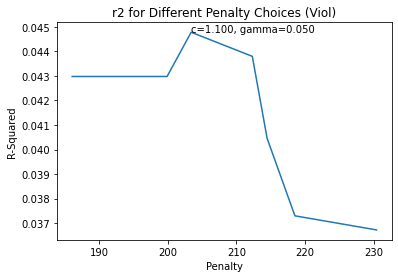

In [80]:
xlineViol, ylineViol = zip(*sorted(zip(xlineViol, ylineViol)))

plt.plot(xlineViol, ylineViol)
plt.title('r2 for Different Penalty Choices (Viol)')
plt.xlabel('Penalty')
plt.ylabel('R-Squared')
myText= 'c={:.3f}, gamma={:.3f}'.format(cViol, gViol)
plt.text(xmaxViol, maxViol, myText)
plt.show()

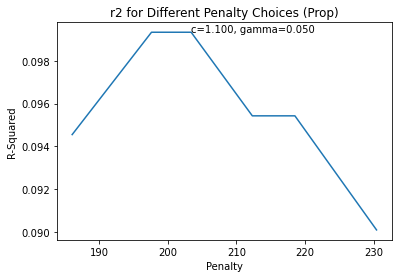

In [81]:
xlineProp, ylineProp = zip(*sorted(zip(xlineProp, ylineProp)))

plt.plot(xlineProp, ylineProp)
plt.title('r2 for Different Penalty Choices (Prop)')
plt.xlabel('Penalty')
plt.ylabel('R-Squared')
myText= 'c={:.3f}, gamma={:.3f}'.format(cProp, gProp)
plt.text(xmaxProp, maxProp, myText)
plt.show()

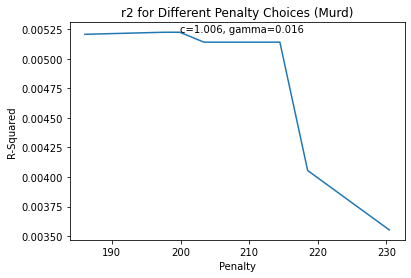

In [82]:
xlineMurd, ylineMurd = zip(*sorted(zip(xlineMurd, ylineMurd)))

plt.plot(xlineMurd, ylineMurd)
plt.title('r2 for Different Penalty Choices (Murd)')
plt.xlabel('Penalty')
plt.ylabel('R-Squared')
myText= 'c={:.3f}, gamma={:.3f}'.format(cMurd, gMurd)
plt.text(xmaxMurd, maxMurd, myText)
plt.show()